# Multiprocessing on GPU

In this tutorial, the idea is to parallelized the reading of several HDF5 files in different processes and to perform the azimuthal integration on the GPU together with the Bitshuffle-LZ decompression.

The size of the problem is 1000 files containing 1000 frames each of 4Mpix. Reduced data are 1000x1000x1000 in single precision float.

This is an extreme case where we will try how to use all resources of the computer, so the first thing to do is to determine the topology of the computer:

**Disclaimer:**
* We use `multiprocess` instead of the `multiprocessing` library to be able to demonstrate the precedure with the jupuyter notebook.

In [19]:
%matplotlib inline
#Topology of the computer:
!lstopo topo.png

Failed to open topo.png for writing (File exists)


![Computer topology](topo.png "Computer topology")

In [23]:
import os
import glob
import concurrent
import time
import json
from matplotlib.pyplot import subplots
import multiprocess
from multiprocess import Process, Value, Array
if "mpctx" in globals():
    mpctx = multiprocess.get_context('spawn')
else:
    multiprocess.set_start_method('spawn')
    mpctx = multiprocess.get_context('spawn')
import numpy
import hdf5plugin
import h5py
import pyFAI
print("pyFAI version: ", pyFAI.version)
import SharedArray
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
import inspect
import collections
Item = collections.namedtuple("Item", "index filename")
MAIN_PROCESS = multiprocess.parent_process() is None
print(ocl)

pyFAI version:  0.22.0-dev10
OpenCL devices:
[0] NVIDIA CUDA: (0,0) NVIDIA RTX A5000, (0,1) Quadro M2000
[1] Intel(R) OpenCL: (1,0) Intel(R) Xeon(R) CPU E5-1650 v4 @ 3.60GHz
[2] Intel(R) OpenCL: (2,0) Intel(R) Xeon(R) CPU E5-1650 v4 @ 3.60GHz
[3] Intel(R) FPGA Emulation Platform for OpenCL(TM): (3,0) Intel(R) FPGA Emulation Device


In [27]:
#This cell contains the parameters for all the processing
params = {
    "DEVICES": [[0,0],[0,1]],
    "NWORKERS": 32,
    "FRAME_PER_FILE": 1000,
    "NFILES" : 1000,
    "NBINS" : 1000,
    "DETECTOR":"Eiger_4M",
    "pathname" : "/tmp/big_%04d.h5",
    "pathmask" : "/tmp/big_????.h5",
    "dtype" : "float32",
    "SHARED_NAME" : "shm://multigpu",
    "array_shape" : [1000, 1000, 1000],
    }
with open("param.json", "w") as w: w.write(json.dumps(params, indent=2))
for k,v in params.items():
    globals()[k] = v

'/tmp/big_????.h5'

In [4]:
def build_integrator(detector=DETECTOR):
    "Build an azimuthal integrator with a dummy geometry"
    geo = {"detector": detector, 
           "wavelength": 1e-10, 
           "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
    ai = pyFAI.load(geo)
    return ai

In [5]:
# Generate a set of files
def generate_one_frame(ai, unit="q_nm^-1", dtype="uint32"):
    """Prepare a frame with little count so that it compresses well"""
    qmax = ai.array_from_unit(unit=unit).max()
    q = numpy.linspace(0, qmax, 100)
    img = ai.calcfrom1d(q, 100/(1+q*q))
    frame = numpy.random.poisson(img).astype(dtype)
    return frame

def generate_files(img):
    cmp = hdf5plugin.Bitshuffle()
    filename = pathname%0
    shape = img.shape
    with h5py.File(filename, "w") as h:
        ds = h.create_dataset("data", shape=(FRAME_PER_FILE,)+shape, chunks=(1,)+shape, dtype=img.dtype, **cmp) 
        for i in range(FRAME_PER_FILE):
            ds[i] = img + i%500 #Each frame has a different value to prevent caching effects
    res = [filename]
    for i in range(1, NFILES):
        new_file = pathname%i
        os.link(filename,new_file)
        res.append(new_file)
    return res

# Create a set of files with dummy data in them:
if len(glob.glob(pathmask)) == NFILES: 
    input_files = glob.glob(pathmask)
    input_files.sort()
else:
    for f in glob.glob(pathmask):
        os.remove(f)
    input_files = generate_files(generate_one_frame(build_integrator(DETECTOR)))
input_files[:5]

['/tmp/big_0000.h5',
 '/tmp/big_0001.h5',
 '/tmp/big_0002.h5',
 '/tmp/big_0003.h5',
 '/tmp/big_0004.h5']

In [6]:
#This is allows to create and destroy shared numpy arrays

def create_shared_array(shape, dtype="float32", name=SHARED_NAME, create=False):
    if create:
        ary = SharedArray.create(name, shape, dtype=dtype)
    else:
        ary = SharedArray.attach(name)
    return ary

def release_shared(name=SHARED_NAME):
    if MAIN_PROCESS:
        SharedArray.delete(name)

result_array = create_shared_array(array_shape, dtype, SHARED_NAME, create=MAIN_PROCESS)

In [7]:
def worker(rank, queue, shm_name, counter):
    """Function representing one worker, used in a pool of worker.
    
    :param rank: integer, index of the worker.
    :param queue: input queue, expects Item with index and name of the file to process
    :param shm_name: name of the output shared memory to put integrated intensities
    :param counter: decremented when quits
    :return: nothing, used in a process.
    """
    def new_engine(engine, wg):
        "Change workgroup size of an engine"
        return engine.__class__((engine._data, engine._indices, engine._indptr), 
                              engine.size, empty=engine.empty, unit=engine.unit, 
                              bin_centers=engine.bin_centers, azim_centers = engine.azim_centers,  
                              ctx=engine.ctx, block_size=wg)
    #imports:
    import pyFAI
    import numpy
    import SharedArray
    from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
    import h5py
    import json
    #load parameters:
    for k,v in json.load(open("param.json")).items():
        globals()[k] = v
    #Start up the integrator:
    ai = pyFAI.load({"detector": DETECTOR, 
                     "wavelength": 1e-10, 
                     "rot3":0})
    blank = numpy.zeros(ai.detector.shape, dtype="uint32")
    method = ("full", "csr", "opencl", DEVICES[rank%len(DEVICES)])
    res = ai.integrate1d(blank, param.NBINS, method=method)
    omega = ai.solidAngleArray()
    engine = ai.engines[res.method].engine
    print(res.method)
    omega_crc = engine.on_device["solidangle"]
    engine = new_engine(engine, 512)
   
    gpu_decompressor = BitshuffleLz4(2000000, size, dtype=blank.dtype, ctx=engine.ctx)
    gpu_decompressor.block_size = 128
    result_array = SharedArray.attach(SHARED_NAME)
    
    while True:
        item = queue.get()
        print(f"{rank}: got {item}")
        index = item.index
        if index<0: 
            with counter.get_lock():
                counter.value -= 1
            return
        with h5py.File(item.filename, "r") as h5:
            ds = h5["data"]
            for i in range(ds.id.get_num_chunks()):
                filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
                if filter_mask == 0:
                    # print(f"{rank}: process frame #{i}")
                    dec = gpu_decompressor(chunk)
                    intensity = engine.integrate_ng(dec, solidangle=omega, solidangle_checksum=omega_crc).intensity
                    result_array[index, i,:] = intensity.astype(param.dtype)

In [8]:
def build_pool(nbprocess, queue, shm_name, counter):
    """Build a pool of processes with workers, and starts them"""
    pool = [Process(target=worker, name=f"worker_{i:02d}", args=(i, queue, shm_name, counter)) for i in range(nbprocess)]
    for process in pool:
        process.start()
    return pool

def end_pool(pool, queue):
    """Ends all processes from a pool by sending them a "kill-pill"""
    for process in pool:
        queue.put(Item(-1, None))


In [9]:
# Build the pool of workers
start_time = time.perf_counter()
queue = mpctx.Queue()
counter = mpctx.Value("i", NWORKERS)
pool = [Process(target=worker, name=f"worker_{i:02d}", args=(i, queue, SHARED_NAME, counter)) for i in range(NWORKERS)]
pool

[<Process name='worker_00' parent=1618548 initial>,
 <Process name='worker_01' parent=1618548 initial>,
 <Process name='worker_02' parent=1618548 initial>,
 <Process name='worker_03' parent=1618548 initial>,
 <Process name='worker_04' parent=1618548 initial>,
 <Process name='worker_05' parent=1618548 initial>]

In [10]:
for p in pool: p.start()
pool

[<Process name='worker_00' pid=1618575 parent=1618548 started>,
 <Process name='worker_01' pid=1618576 parent=1618548 started>,
 <Process name='worker_02' pid=1618577 parent=1618548 started>,
 <Process name='worker_03' pid=1618578 parent=1618548 started>,
 <Process name='worker_04' pid=1618579 parent=1618548 started>,
 <Process name='worker_05' pid=1618580 parent=1618548 started>]

In [11]:
for idx, fn in enumerate(input_files):        queue.put(Item(idx, fn))
pool

[<Process name='worker_00' pid=1618575 parent=1618548 started>,
 <Process name='worker_01' pid=1618576 parent=1618548 started>,
 <Process name='worker_02' pid=1618577 parent=1618548 started>,
 <Process name='worker_03' pid=1618578 parent=1618548 started>,
 <Process name='worker_04' pid=1618579 parent=1618548 started>,
 <Process name='worker_05' pid=1618580 parent=1618548 started>]

In [12]:
end_pool(pool, queue)
while counter.value:
    time.sleep(1e-3)
run_time = time.perf_counter()-start_time
print(f"run-time: {run_time:.3f}s")

run-time: 141.852s


In [13]:
counter.value

0

In [14]:
result_array

array([[[1.01676102e+02, 9.65956879e+01, 1.00264305e+02, ...,
         5.77889204e-01, 7.37409592e-01, 7.65784085e-01],
        [1.02676102e+02, 9.75956879e+01, 1.01264305e+02, ...,
         1.65420544e+00, 1.81388271e+00, 1.84239841e+00],
        [1.03676102e+02, 9.85956879e+01, 1.02264305e+02, ...,
         2.73052168e+00, 2.89035583e+00, 2.91901278e+00],
        ...,
        [5.98676086e+02, 5.93595825e+02, 5.97264465e+02, ...,
         5.35507080e+02, 5.35744568e+02, 5.35843140e+02],
        [5.99676086e+02, 5.94595764e+02, 5.98264526e+02, ...,
         5.36583374e+02, 5.36820984e+02, 5.36919739e+02],
        [6.00676147e+02, 5.95595764e+02, 5.99264465e+02, ...,
         5.37659668e+02, 5.37897461e+02, 5.37996338e+02]],

       [[1.01676102e+02, 9.65956879e+01, 1.00264305e+02, ...,
         5.77889204e-01, 7.37409592e-01, 7.65784085e-01],
        [1.02676102e+02, 9.75956879e+01, 1.01264305e+02, ...,
         1.65420544e+00, 1.81388271e+00, 1.84239841e+00],
        [1.03676102e+02, 

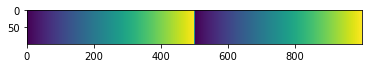

In [16]:
fig, ax = subplots()
ax.imshow(result_array[:,:,5])

In [17]:
release_shared(SHARED_NAME)

In [18]:
100*1000/run_time

704.9579449384653